## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [ ]:
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio
# %pip install scikit-learn pandas matplotlib

In [4]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

### Загрузка данных

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/compling/NLP-7-cnn_keras/lenta_40k.csv.zip')

In [7]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [8]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
len(vocab)

354611

In [11]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

24091

In [13]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [15]:
# переводим тексты в последовательности индексов
# каждый текст теперь – это список индексов токенов, из которых он состоит
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [16]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [17]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN, MEAN_LEN
# максимальная длина сильно больше средней длины текста,

(1748, 170.0)

In [19]:
# поэтому паддинг сделаем до значения чуть больше среднего
MAX_LEN = int(MEAN_LEN + 30)

In [20]:
# паддинг, в керасе есть отдельная функция
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
# на входе теперь матрица X: 44356 – всего индексов токенов и 200 – длина каждого текста в токенах
X.shape

(44356, 200)

In [42]:
# создаем словарь, маппинг индекс в лэйбл, лэйбл в индекс
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [43]:
# Категории (темы) преобразуются в one-hot кодировку,
# чтобы каждый правильный ответ был массивом из 0 и 1 в той позиции, которому классу соответствует этот текст
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [55]:
# всего 19 классов
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Колбэки

In [45]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

### Модель 1




In [58]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

conv1 = keras.layers.Conv1D(kernel_size=5, filters=50, strides=1,
                                              activation='relu')(embeddings)
pool1 = keras.layers.AveragePooling1D(pool_size=5)(conv1)
conv2 = keras.layers.Conv1D(kernel_size=9, filters=35, strides=3,
                                              activation='relu')(pool1)
pool2 = keras.layers.MaxPooling1D(pool_size=3)(conv2)

concat = keras.layers.Flatten()(pool2)
dense1 = keras.layers.Dense(50, activation='relu')(concat)
dense2 = keras.layers.Dense(70, activation='relu')(dense1)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense2)


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])

In [28]:
keras.metrics.F1Score?

In [59]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          2409200   
                                                                 
 conv1d_12 (Conv1D)          (None, 196, 50)           25050     
                                                                 
 average_pooling1d_6 (Avera  (None, 39, 50)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_13 (Conv1D)          (None, 11, 35)            15785     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 3, 35)             0         
 g1D)                                                      

In [60]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=50,
         callbacks=[checkpoint, early_stop])

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 2.4694 - f1: 0.0912
Epoch 1: val_f1 improved from 0.07382 to 0.08075, saving model to model.weights.h5
43/43 [==============================] - 10s 186ms/step - loss: 2.4694 - f1: 0.0912 - val_loss: 2.2607 - val_f1: 0.0808
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 2.1090 - f1: 0.1683
Epoch 2: val_f1 improved from 0.08075 to 0.20121, saving model to model.weights.h5
43/43 [==============================] - 6s 128ms/step - loss: 2.1090 - f1: 0.1683 - val_loss: 2.0106 - val_f1: 0.2012
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.7645 - f1: 0.3165
Epoch 3: val_f1 improved from 0.20121 to 0.40113, saving model to model.weights.h5
43/43 [==============================] - 7s 155ms/step - loss: 1.7645 - f1: 0.3165 - val_loss: 1.5884 - val_f1: 0.4011
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 1.2553 - f1: 0.5449
Epoch 4: val_f1 improved from 0.40113 to 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


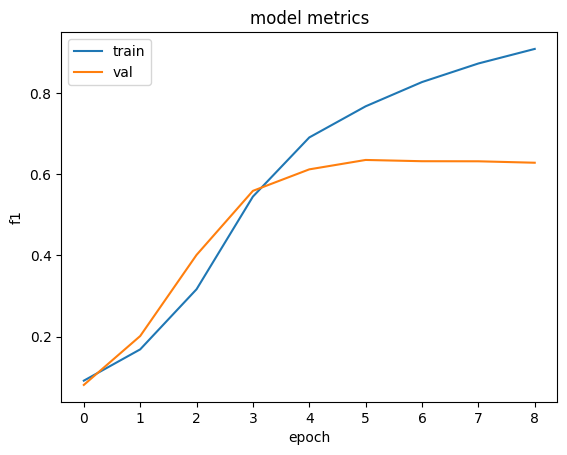

In [61]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Модель 2

In [62]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

drop1 = keras.layers.Dropout(0.1)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=5, filters=50, strides=1,
                                              activation='relu')(embeddings)
pool1 = keras.layers.AveragePooling1D(pool_size=5)(conv1)
conv2 = keras.layers.Conv1D(kernel_size=9, filters=35, strides=3,
                                              activation='relu')(pool1)
pool2 = keras.layers.MaxPooling1D(pool_size=3)(conv2)
drop2 = keras.layers.Dropout(0.2)(pool2)

concat = keras.layers.Flatten()(drop2)
dense1 = keras.layers.Dense(50, activation='relu')(concat)
dense2 = keras.layers.Dense(70, activation='relu')(dense1)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense2)


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', # функция потерь
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])

In [63]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 100)          2409200   
                                                                 
 conv1d_14 (Conv1D)          (None, 196, 50)           25050     
                                                                 
 average_pooling1d_7 (Avera  (None, 39, 50)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_15 (Conv1D)          (None, 11, 35)            15785     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 3, 35)             0         
 g1D)                                                      

In [64]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=50,
         callbacks=[checkpoint, early_stop])

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 2.5204 - f1: 0.1201
Epoch 1: val_f1 did not improve from 0.63514
43/43 [==============================] - 11s 175ms/step - loss: 2.5204 - f1: 0.1201 - val_loss: 2.2759 - val_f1: 0.0881
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 2.1575 - f1: 0.1290
Epoch 2: val_f1 did not improve from 0.63514
43/43 [==============================] - 5s 113ms/step - loss: 2.1575 - f1: 0.1290 - val_loss: 2.0546 - val_f1: 0.1918
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.8312 - f1: 0.2926
Epoch 3: val_f1 did not improve from 0.63514
43/43 [==============================] - 4s 98ms/step - loss: 1.8312 - f1: 0.2926 - val_loss: 1.5845 - val_f1: 0.4063
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 1.2670 - f1: 0.5292
Epoch 4: val_f1 did not improve from 0.63514
43/43 [==============================] - 6s 127ms/step - loss: 1.2670 - f1: 0.5292 - val_loss: 1.2213 - val_f1:

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


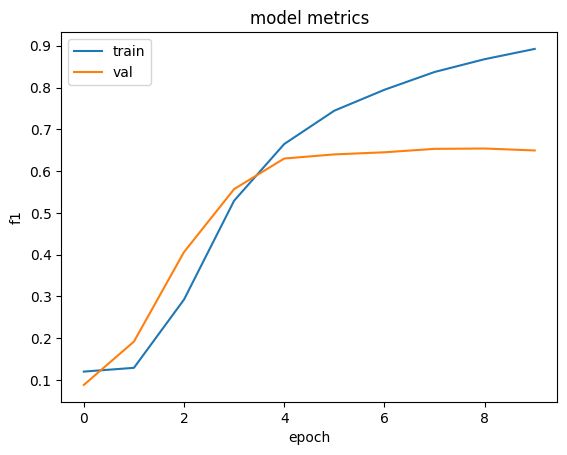

In [65]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Модель 3

In [93]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.1)(embeddings)
convs = []

for ks in [3, 4, 5, 7, 10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=50, padding='same', strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=60, padding='same', strides=3,
                                                  activation='relu')(conv1)
    conv3 = keras.layers.Conv1D(kernel_size=ks, filters=35, padding='same', strides=7,
                                                  activation='relu')(conv2)
    conv4 = keras.layers.Conv1D(kernel_size=ks, filters=20, padding='same', strides=2, kernel_regularizer='l2',
                                                  activation='relu')(pool1)
    convs.append(conv2)

concat = keras.layers.concatenate(convs, axis=2)

conv_global1 = keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', strides=1)(concat)
pool1 = keras.layers.AveragePooling1D(pool_size=5)(conv_global1)
conv_global2 = keras.layers.Conv1D(kernel_size=10, filters=30, strides=6)(pool1)
pool2 = keras.layers.GlobalMaxPooling1D()(conv_global2)
flatten = keras.layers.Flatten()(pool2)
drop2 = keras.layers.Dropout(0.2)(flatten)
dense1 = keras.layers.Dense(50, activation='relu')(drop2)
dense2 = keras.layers.Dense(70, activation='relu')(dense1)
drop3 = keras.layers.Dropout(0.3)(dense2)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(drop3)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])


In [94]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 embedding_19 (Embedding)    (None, 200, 100)             2409200   ['input_20[0][0]']            
                                                                                                  
 conv1d_179 (Conv1D)         (None, 200, 50)              15050     ['embedding_19[0][0]']        
                                                                                                  
 conv1d_183 (Conv1D)         (None, 200, 50)              20050     ['embedding_19[0][0]']        
                                                                                           

In [95]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=50,
         callbacks=[checkpoint, early_stop])

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 2.4799 - f1: 0.1201
Epoch 1: val_f1 did not improve from 0.65405
43/43 [==============================] - 17s 240ms/step - loss: 2.4799 - f1: 0.1201 - val_loss: 2.1966 - val_f1: 0.1213
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 2.0024 - f1: 0.2622
Epoch 2: val_f1 did not improve from 0.65405
43/43 [==============================] - 8s 188ms/step - loss: 2.0024 - f1: 0.2622 - val_loss: 1.5316 - val_f1: 0.3897
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.3632 - f1: 0.5017
Epoch 3: val_f1 did not improve from 0.65405
43/43 [==============================] - 7s 165ms/step - loss: 1.3632 - f1: 0.5017 - val_loss: 1.3222 - val_f1: 0.5363
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 1.1009 - f1: 0.6050
Epoch 4: val_f1 did not improve from 0.65405
43/43 [==============================] - 8s 178ms/step - loss: 1.1009 - f1: 0.6050 - val_loss: 1.3634 - val_f1

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


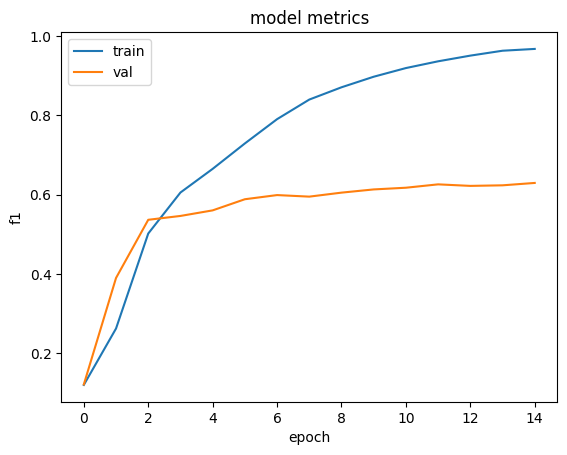

In [96]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()